# Day 3
## Optimizers
- implement SGD, Momentum (with Nesterov trick), AdamW

## Optimizers

### SGD
At each training step, given parameters $\theta$ (weights), gradient $g = \nabla_\theta L(\theta)$ and a learning rate $\eta$, take: 
$$ \theta \leftarrow \theta - \eta g $$

**Real implementation:** 
* learning rate schedule (allow lr to decay over epochs)
* momentum: accumulate a velocity term to accelerate convergence
* Nesterov momentum: "look ahead" before aplying momentum
* weight decay
* clipping 
* batching 

### Momentum 

Momentum beats on problems with strong curvature anisotropy (ravines/ill conditioning) or saddle-heavy landscapes.

### AdamW
AdamW

In [1]:
from optimizers.sgd import SGD
from optimizers.momentum import Momentum
from optimizers.adamw import AdamW

In [ ]:
## Comparison

In [ ]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

def rosenbrock(xy):
    x,y = xy
    return (1-x)**2 + 100*(y - x**2)**2

def rosen_grad(xy):
    x,y = xy
    dfdx = -2*(1-x) - 400*x*(y - x**2)
    dfdy = 200*(y - x**2)
    return np.array([dfdx, dfdy])

def run_optimizer(opt, x0, grad_fn, max_steps=10000, tol=1e-6):
    """Run the optimizer on the Rosenbrock function.

    Args:
        opt: Optimizer instance (e.g., SGD, MomentumSGD).
        x0: Initial point as a numpy array.
        grad_fn: Gradient function to compute gradients.
        max_steps: Maximum number of optimization steps.
        tol: Tolerance for stopping criterion.

    Returns:
        int: Number of steps taken until convergence or max_steps reached.

    """
    loss = []
    x = opt.params[0]["value"]
    x[:] = x0
    for t in range(max_steps):
        g = grad_fn(x)
        opt.params[0]["grad"][:] = g
        opt.step()
        opt.zero_grad()
        loss.append(rosenbrock(x))
        if np.linalg.norm(g) < tol:
            return t+1
    return loss

# Example: Rosenbrock
x_param = {"value": np.array([-1.2, 1.0], dtype=float), "grad": np.zeros(2)}
loss_sgd = run_optimizer(SGD([x_param.copy()], lr=1e-3), np.array([-1.2,1.0]), rosen_grad)
loss_momentum = run_optimizer(Momentum([x_param.copy()], lr=1e-3, momentum=0.9), np.array([-1.2,1.0]), rosen_grad)

In [ ]:
fig, ax = plt.subplots()
ax.plot(loss_sgd, label="SGD")
ax.plot(loss_momentum, label="Momentum")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("SGD vs Momentum Loss")
ax.legend()
ax.set_ylim(-1,10)

### Synth Dataset + decision boundary

In [ ]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=1000, noise=0.1, random_state=42)
fig, ax = plt.subplots()
ax.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='coolwarm', s=10)
ax.set_title("Synthetic Moons Dataset")

In [2]:
MLP_moons = MLP(D=2, H=10, C=2, seed=42)
ds_moons = ArrayDataset(X_moons, y_moons)
loader_moons = Dataloader(ds_moons, batch_size=32, shuffle=True, drop_last=True, seed=42)

NameError: name 'MLP' is not defined

In [ ]:
num_classes = 2

def to_one_hot(y, num_classes):
    # y: (B,) integer labels
    oh = np.zeros((y.shape[0], num_classes), dtype=np.float32)
    oh[np.arange(y.shape[0]), y.astype(int)] = 1.0
    return oh


for epoch in range(5000):
    loader_moons.set_epoch(epoch)

    epoch_loss = 0.0
    n_examples = 0
    #print(f"\n[Epoch {epoch}]")


    for xb, yb in loader_moons:
        # Ensure shapes/dtypes are what your MLP expects
        if yb.ndim == 1 or yb.shape[-1] == 1:        # likely indices
            yb_oh = to_one_hot(yb.reshape(-1), num_classes)
        else:
            yb_oh = yb                                # already one-hot
        loss = MLP_moons.sgd_step(xb, yb_oh, lr=0.01, l2=0.0)  # make sure loss is mean over the batch
        batch_size = xb.shape[0]
        epoch_loss += loss * batch_size                # accumulate by sample count
        n_examples += batch_size

    #print(f"[Epoch {epoch}] loss={epoch_loss / n_examples:.4f}")
    #    print(f"Loss: {loss:.4f}")

print(f"Final loss: {epoch_loss / n_examples:.4f}")


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y, ax=None, padding=0.5, resolution=400, cmap="coolwarm"):
    """
    Plots decision regions for a 2D dataset.
    - model must implement .predict(X) -> (N,) class indices
      (or .predict_proba(X) returning probs; we’ll argmax them).
    - X: (N, 2) features
    - y: (N,) class indices OR (N, C) one-hot
    """
    X = np.asarray(X)
    assert X.shape[1] == 2, "This helper expects 2D inputs."
    if y.ndim == 2:
        y_plot = y.argmax(axis=1)
    else:
        y_plot = y

    # grid limits
    x_min, x_max = X[:,0].min() - padding, X[:,0].max() + padding
    y_min, y_max = X[:,1].min() - padding, X[:,1].max() + padding

    # meshgrid
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # predict on grid
    try:
        Z = model.predict(grid)                 # preferred (already argmaxed)
    except Exception:
        Z = model.predict_proba(grid).argmax(1) # fallback if only proba exists
    Z = Z.reshape(xx.shape)

    # plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))

    # background decision regions
    im = ax.contourf(xx, yy, Z, levels=np.unique(Z).size, alpha=0.3, antialiased=True)

    # decision boundary lines (optional, looks nice)
    ax.contour(xx, yy, Z, levels=np.unique(Z), linewidths=1.0, colors='k', alpha=0.4)

    # scatter training data
    scatter = ax.scatter(X[:,0], X[:,1], c=y_plot, s=25, edgecolor='k', linewidth=0.4, cmap=cmap)

    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_title("Decision boundary")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # legend-like handles for classes (optional)
    # If


NameError: name 'MLP_moons' is not defined

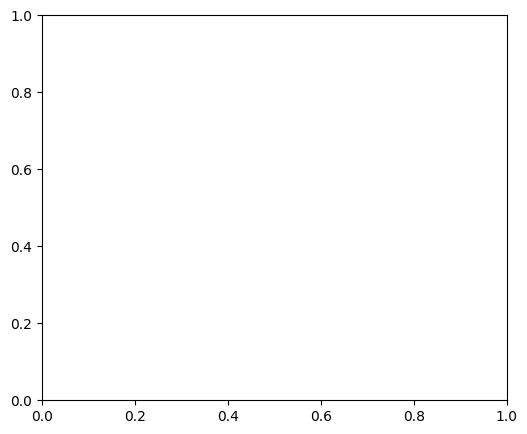

In [4]:
fig, ax = plt.subplots(figsize=(6,5))
plot_decision_boundary(MLP_moons, X_moons, y_moons, ax=ax, padding=0.5, resolution=400)
plt.show()